<a href="https://colab.research.google.com/github/HOSilvL/DL_Project_Study_2021/blob/main/CH2_Object%20Detection%20API%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%B4%20%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%97%90%20%EC%A3%BC%EC%84%9D%20%EB%8B%AC%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pathlib
import six.moves.urllib as urllib
import tarfile
from PIL import Image
from tqdm import tqdm
from time import gmtime, strftime
import json

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
from google.colab.patches import cv2_imshow
import cv2

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 2927 (delta 737), reused 1277 (delta 421), pack-reused 0
Receiving objects: 100% (2927/2927), 33.00 MiB | 27.45 MiB/s, done.
Resolving deltas: 100% (737/737), done.


In [ ]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1665976 sha256=4007dd94c1304c7a9c2831bbbc156af21df6299d7ad2b54ed016bd8be6854ec3
  Stored in directory: /tmp/pip-ephem-wheel-cache-9abb3b10/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=ea82cfd0a74ee6c5c9210ca3ee1b1fa0e2bcc0ee724920557e45455084949f73
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=8cd84f3359d1f85e5f139ea6fd5cc6273fd0a3bbf0f54fe3bae14f765eab4ae6
  Stored in directory: /r



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

[[[21 22 27]
  [14 15 20]
  [ 8  9 13]
  ...
  [18 17 13]
  [17 16 12]
  [19 18 14]]

 [[22 23 28]
  [ 8  9 13]
  [ 0  1  5]
  ...
  [21 20 15]
  [21 20 15]
  [26 25 20]]

 [[37 38 42]
  [15 16 20]
  [ 1  2  4]
  ...
  [27 26 21]
  [28 27 22]
  [32 31 26]]

 ...

 [[62 13  6]
  [36  0  4]
  [15  0 14]
  ...
  [44 59 78]
  [43 58 77]
  [42 57 76]]

 [[53 10  3]
  [29  0  3]
  [ 9  0 18]
  ...
  [42 57 76]
  [41 56 75]
  [40 55 74]]

 [[44  5  0]
  [23  0  1]
  [ 6  0 20]
  ...
  [39 54 73]
  [39 54 73]
  [38 53 72]]]


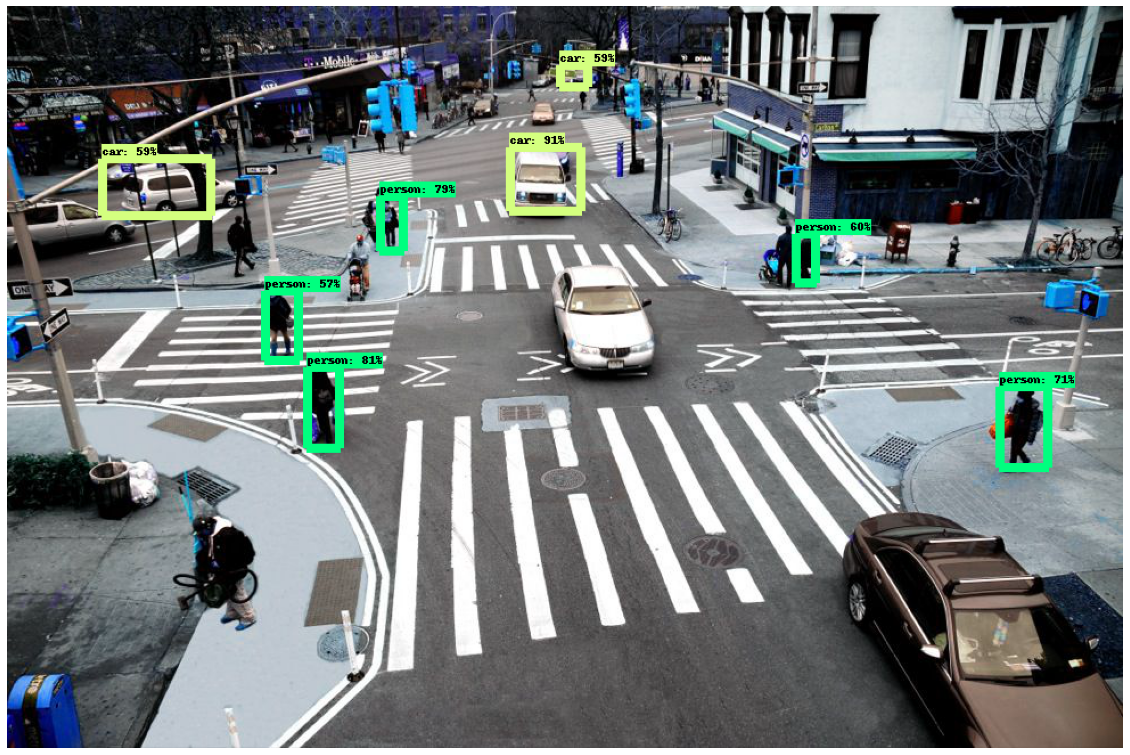

In [ ]:
try:
    from moviepy.editor import VideoFileClip
except:
    # If FFmpeg (https://www.ffmpeg.org/) is not found on the computer,
    # it will be downloaded from Internet (an Internet connect is needed)
    import imageio
    imageio.plugins.ffmpeg.download()
    from moviepy.editor import VideoFileClip

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

class DetectionObj(object):
    """
    DetectionObj is a class suitable to leverage Google Tensorflow
    detection API for image annotation from different sources:
    files, images acquired by own's webcam, videos.
    """

    def __init__(self, model='ssd_mobilenet_v1_coco_11_06_2017'):
        """
        The instructions to be run when the class is instantiated
        """

        # Path where the Python script is being run
        self.CURRENT_PATH = os.getcwd()

        # Path where to save the annotations (it can be modified)
        self.TARGET_PATH = self.CURRENT_PATH

        # Selection of pre-trained detection models
        # from the Tensorflow Model Zoo
        self.MODELS = ["ssd_mobilenet_v1_coco_11_06_2017",
                       "ssd_inception_v2_coco_11_06_2017",
                       "rfcn_resnet101_coco_11_06_2017",
                       "faster_rcnn_resnet101_coco_11_06_2017",
                       "faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017"
                       ]

        # Setting a threshold for detecting an object by the models
        self.THRESHOLD = 0.25 # Most used threshold in practice

        # Checking if the desired pre-trained detection model is available
        if model in self.MODELS:
            self.MODEL_NAME = model
        else:
            # Otherwise revert to a default model
            print("Model not available, reverted to default", self.MODELS[0])
            self.MODEL_NAME = self.MODELS[0]

        # The file name of the Tensorflow frozen model
        self.CKPT_FILE = os.path.join(self.CURRENT_PATH, 'object_detection',
                                      self.MODEL_NAME, 'frozen_inference_graph.pb')

        # Attempting loading the detection model, if not available on disk,
        # it will be downloaded from Internet(an Internet connection is required)
        try:
            self.DETECTION_GRAPH = self.load_frozen_model()
        except:
            print ('Couldn\'t find', self.MODEL_NAME)
            self.download_frozen_model()
            self.DETECTION_GRAPH = self.load_frozen_model()

        # Loading the labels of the classes recognized by the detection model
        self.NUM_CLASSES = 90
        path_to_labels = os.path.join(self.CURRENT_PATH,
                                      'object_detection', 'data', 'mscoco_label_map.pbtxt')
        label_mapping = label_map_util.load_labelmap(path_to_labels)
        extracted_categories = label_map_util.convert_label_map_to_categories(label_mapping,
                                                                    max_num_classes=self.NUM_CLASSES,
                                                                    use_display_name=True)
        self.LABELS = {item['id']: item['name'] for item in extracted_categories}
        self.CATEGORY_INDEX = label_map_util.create_category_index(extracted_categories)

        # Starting the tensorflow session
        self.TF_SESSION = tf.compat.v1.Session(graph=self.DETECTION_GRAPH)

    def load_frozen_model(self):
        """
        Loading frozen detection model in ckpt file from disk to memory 
        """
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.compat.v1.GraphDef()
            with tf.compat.v1.gfile.GFile(self.CKPT_FILE, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        return detection_graph

    def download_frozen_model(self):
        """
        Downloading frozen detection model from Internet 
        when not available on disk 
        """
        def my_hook(t):
            """
            Wrapping tqdm instance in order to monitor URLopener  
            """
            last_b = [0]

            def inner(b=1, bsize=1, tsize=None):
                if tsize is not None:
                    t.total = tsize
                t.update((b - last_b[0]) * bsize)
                last_b[0] = b

            return inner

        # Opening the url where to find the model
        model_filename = self.MODEL_NAME + '.tar.gz'
        download_url = 'http://download.tensorflow.org/models/object_detection/'
        opener = urllib.request.URLopener()

        # Downloading the model with tqdm estimations of completion
        print('Downloading ...')
        with tqdm() as t:
            opener.retrieve(download_url + model_filename,
                            model_filename, reporthook=my_hook(t))

        # Extracting the model from the downloaded tar file
        print ('Extracting ...')
        tar_file = tarfile.open(model_filename)
        for file in tar_file.getmembers():
            file_name = os.path.basename(file.name)
            if 'frozen_inference_graph.pb' in file_name:
                tar_file.extract(file, os.path.join(self.CURRENT_PATH,
                                                    'object_detection'))

    def load_image_from_disk(self, image_path):
        """
        Loading an image from disk
        """
        return Image.open(image_path)

    def load_image_into_numpy_array(self, image):
        """
        Turning an image into a Numpy ndarray
        """
        try:
            (im_width, im_height) = image.size
            return np.array(image.getdata()).reshape(
                (im_height, im_width, 3)).astype(np.uint8)
        except:
            # If the previous procedure fails, we expect the
            # image is already a Numpy ndarray
            return image

    def detect(self, images, annotate_on_image=True):
        """
        Processing a list of images, feeding it into the detection
        model and getting from it scores, bounding boxes and predicted
        classes present in the images
        """
        if type(images) is not list:
            images = [images]
        results = list()
        for image in images:
            # the array based representation of the image will be used later in order to prepare the resulting
            # image with boxes and labels on it.
            image_np = self.load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = self.DETECTION_GRAPH.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = self.DETECTION_GRAPH.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score could be shown on the result image, together with the class label.
            scores = self.DETECTION_GRAPH.get_tensor_by_name('detection_scores:0')
            classes = self.DETECTION_GRAPH.get_tensor_by_name('detection_classes:0')
            num_detections = self.DETECTION_GRAPH.get_tensor_by_name('num_detections:0')
            # Actual detection happens here
            (boxes, scores, classes, num_detections) = self.TF_SESSION.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            if annotate_on_image:
                new_image = self.detection_on_image(image_np, boxes, scores, classes)
                results.append((new_image, boxes, scores, classes, num_detections))
            else:
                results.append((image_np, boxes, scores, classes, num_detections))
        return results

    def detection_on_image(self, image_np, boxes, scores, classes):
        """
        Overimposing detection boxes on the images over the detected classes: 
        """
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            self.CATEGORY_INDEX,
            use_normalized_coordinates=True,
            line_thickness=8)
        return image_np

    def visualize_image(self, image_np, image_size=(400, 300), latency=3, bluish_correction=True):
        """
        Visualizing an image
        """
        height, width, depth = image_np.shape
        reshaper = height / float(image_size[0])
        width = int(width / reshaper)
        height = int(height / reshaper)
        id_img = 'preview_' + str(np.sum(image_np))
      
        if bluish_correction:
            RGB_img = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(20,30))
            plt.imshow(RGB_img)
            print(image_np)
            plt.axis("off")
            plt.show()
        else:
            plt.figure(figsize=(20,30))
            plt.imshow(image_np)
            print(image_np)
            plt.axis("off")
            plt.show()

    def serialize_annotations(self, boxes, scores, classes, filename='data.json'):
        """
        Saving annotations to disk, on a JSON file
        """
        threshold = self.THRESHOLD
        valid = [position for position, score in enumerate(scores[0]) if score > threshold]
        if len(valid) > 0:
            valid_scores = scores[0][valid].tolist()
            valid_boxes  = boxes[0][valid].tolist()
            valid_class = [self.LABELS[int(a_class)] for a_class in classes[0][valid]]
            with open(filename, 'w') as outfile:
                json_data = json.dumps({'classes': valid_class,
                                        'boxes':valid_boxes, 'scores': valid_scores})
                json.dump(json_data, outfile)

    def get_time(self):
        """
        Returning a string reporting the actual date and time
        """
        return strftime("%Y-%m-%d_%Hh%Mm%Ss", gmtime())

    def annotate_photogram(self, photogram):
        """
        Annotating a video's photogram with bounding boxes
        over detected classes
        """
        new_photogram, boxes, scores, classes, num_detections = self.detect(photogram)[0]
        return new_photogram

    def capture_webcam(self):
        """
        Capturing an image from the integrated Webcam
        """
        def get_image(device):
            """
            Function to capture a single image from the camera and return it in PIL format
            """
            retval, im = device.read()
            return im

        # Setting the integrated webcam
        camera_port = 0

        # Number of frames to discard as the camera adjusts to surrounding lights
        ramp_frames = 30

        # Initializing the webcam by cv2.VideoCapture.
        camera = cv2.VideoCapture(camera_port)

        # Ramping the camera - all these frames will be discarded as the camera
        # adjusts to the light levels
        print("Setting the webcam")
        for i in range(ramp_frames):
            _ = get_image(camera)

        # Taking the snapshot
        print("Now taking a snapshot ... ", end='')
        camera_capture = get_image(camera)
        print('Done')

        # releasing the camera and making it reusable
        del (camera)
        return camera_capture

    def file_pipeline(self, images, visualize=True):
        """
        A pipeline for processing and annotating lists of
        images to load from disk
        """
        if type(images) is not list:
            images = [images]
        for filename in images:
            single_image = self.load_image_from_disk(filename)
            for new_image, boxes, scores, classes, num_detections in self.detect(single_image):
                self.serialize_annotations(boxes, scores, classes,
                                           filename=filename + ".json")
                if visualize:
                    self.visualize_image(new_image)

    def video_pipeline(self, video, audio=False):
        """
        A pipeline to process a video on disk and annotating it
        by bounding box. The output is a new annotated video.
        """
        clip = VideoFileClip(video)
        new_video = video.split('/')
        new_video[-1] = "annotated_" + new_video[-1]
        new_video = '/'.join(new_video)
        print("Saving annotated video to", new_video)
        video_annotation = clip.fl_image(self.annotate_photogram)
        video_annotation.write_videofile(new_video, audio=audio)

    def webcam_pipeline(self):
        """
        A pipeline to process an image acquired by the internal webcam
        and annotate it, saving a JSON file to disk
        """
        webcam_image = self.capture_webcam()
        filename = "webcam_" + self.get_time()
        saving_path = os.path.join(self.CURRENT_PATH, filename + ".jpg")
        cv2.imwrite(saving_path, webcam_image)
        new_image, boxes, scores, classes, num_detections = self.detect(webcam_image)[0]
        json_obj = {'classes': classes, 'boxes':boxes, 'scores':scores}
        self.serialize_annotations(boxes, scores, classes,
                                   filename=filename+".json")
        self.visualize_image(new_image, bluish_correction=False)


def main():
    detection = DetectionObj(model='ssd_mobilenet_v1_coco_11_06_2017')
    images = ["/content/drive/MyDrive/intersection.jpg"]
    detection.file_pipeline(images)

if __name__ == "__main__":
    main()